In [1]:
#%matplotlib qt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from skimage.transform import resize

import math

import seaborn as sns; sns.set()
np.random.seed(42)

In [2]:
class genere_distributions():
    x_min, x_max = 0., 10.
    y_min, y_max = 0., 10.
    nx, ny = 150, 150
    nx, ny = 500, 500
    offset = -0.1
    
    def __init__(self, mu, sigma, angle, prob_C):
        self.mu = mu
        self.sigma = sigma
        self.angle = angle
        self.prob_C = prob_C
        
        self.genere_grid()
        self.genere_pdf()
        self.colore_zone_influence()


    def genere_grid(self):
        self.xx, self.yy = np.meshgrid(np.linspace(self.x_min, self.x_max, self.nx), 
                                       np.linspace(self.y_min, self.y_max, self.ny))
        self.pos = np.dstack((self.xx, self.yy))
        


    # Modèles génératifs pour les distributions normales 2D 
    # (PDF: probability distribution functions)
    def genere_pdf(self):
        self.modeles = [None]*2
        for i in range(2):
            # Matrice de rotation
            theta = np.radians(self.angle[i])
            c, s = np.cos(theta), np.sin(theta)
            R = np.array(((c, -s), (s, c)))        

            # Matrice de covariance sans rotation
            C = np.array([[self.sigma[i, 0]**2, 0.],[0., self.sigma[i, 1]**2]])

            # Matrice de covariance après rotation
            # new_cov = rotation_matrix @ cov @ rotation_matrix.T
            C = R.dot( C.dot(R.T) )  

            # Génère modele pour PDF normale 2D
            self.modeles[i] = multivariate_normal(self.mu[i,:], C) 

        # Génère PDF individuelles
        pdf0 = self.prob_C[0]*self.modeles[0].pdf(self.pos)
        pdf1 = self.prob_C[1]*self.modeles[1].pdf(self.pos)

        # Masque indiquant la zone d'influence du modèle 1
        self.masque = pdf1 > pdf0

        # PDF globale
        self.pdf = pdf0 + pdf1

        
    # Création de l'image de la PDF globale colorée selon la zone d'influence de chaque PDF individuelle 
    def colore_zone_influence(self):     
        # Colormaps utilisées pour représenter les deux PDF
        v = np.array(cm.viridis.colors)
        g = np.array(cm.plasma.colors)

        # Normalisation de la PDF globale
        Z = 255*(self.pdf - np.min(self.pdf)) / (np.max(self.pdf) - np.min(self.pdf))
        Z = Z.astype(int)

        self.I = np.zeros((self.nx,self.ny,3))

        indx = np.argwhere(self.masque)
        A = Z[self.masque]
        for k, idx in enumerate(indx):
            self.I[idx[0],idx[1],:] = g[A[k]]

        indx = np.argwhere(~self.masque)
        B = Z[~self.masque]
        for k, idx in enumerate(indx):
            self.I[idx[0],idx[1],:] = v[B[k]]
            
        # Localise la position des frontières entre les zones d'influence
        cs = plt.contour(self.xx,self.yy,self.masque, [0.5])
        p = cs.collections[0].get_paths()[0]
        self.frontieres = p.vertices
        
        j = np.round((self.nx-1)*self.frontieres[:,0]/self.x_max).astype(int)
        i = np.round((self.ny-1)*self.frontieres[:,1]/self.y_max).astype(int)
        self.I[i,j,:]=[1., 1., 1.]
        
        plt.imshow(self.I)    


    # Calcule les valeurs de la pdf globale le long des frontières entre les zones
    def pdf_sur_frontieres(self):
        pdf0 = self.prob_C[0]*self.modeles[0].pdf(self.frontieres)
        pdf1 = self.prob_C[1]*self.modeles[1].pdf(self.frontieres)
        self.pdf_front = pdf0 + pdf1
        
    

    # Affiche la fonction de distribution normale des probabilités en 3D et ses contours en 2D
    def affiche_PDF_avec_contours(self, contours_remplis=False, affiche_labels=True, affiche_tickmarks=True):

        fig = plt.figure(figsize = (13,10))
        ax = fig.gca(projection='3d')

        # Surface 3D au dessus
        ax.plot_surface(self.xx, self.yy, self.pdf, rstride=3, cstride=3, linewidth=1, antialiased=True, facecolors=self.I)
 
        # Superpose les frontières entre les zones d'influence
        # self.pdf_sur_frontieres()
        # ax.plot3D(self.frontieres[:,0], self.frontieres[:,1], self.pdf_front, linewidth=3, color='white', zorder=100)
        # ax.plot3D(self.frontieres[:,0], self.frontieres[:,1], self.pdf_front + 0.02, linewidth=3, color='white')

         # Affiche contours 2D et frontières entre les zones d'influence
        if (contours_remplis==True):
            cset = ax.contourf(self.xx, self.yy, self.pdf, zdir='z', offset=self.offset, cmap=cm.hot)
            ax.contour(self.xx, self.yy, self.masque, [0.5], offset=self.offset, linewidths=5., colors='white') 

        else:
            cset = ax.contour(self.xx, self.yy, self.pdf, zdir='z', offset=self.offset, levels = 10, cmap='hot') 
            ax.contour(self.xx, self.yy, self.masque, [0.5], offset=self.offset, linewidths=5., colors='red') 
            

        ax.set_zlim(self.offset,np.max(self.pdf))
        ax.view_init(20, -20)

        if (affiche_labels==True):
            ax.set_ylabel('$x_{2}$', fontsize=18)
            ax.xaxis.set_rotate_label(False)  
            ax.set_xlabel('$x_{1}$', rotation=10, fontsize=18)
            ax.zaxis.set_rotate_label(False)  
            ax.set_zlabel('$f(x_{1},x_{2})$', rotation=0, fontsize=18)

        if (affiche_tickmarks==False):
            # Enlève tickmarks
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
            ax.axes.get_zaxis().set_ticks([])

        plt.show()
    



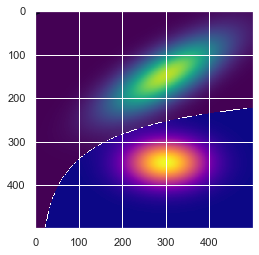

In [3]:
if __name__=='__main__':

    # --------- Cas avec 2 nuages de points avec faible recouvrement: paramètres des gaussiennes
    mu = np.zeros((2,2))
    mu[0,:] = [6., 3.]
    mu[1,:] = [6., 7.]

    sigma = np.zeros((2,2))
    sigma[0,:] = [2., 0.7]
    sigma[1,:] = [1.2, 0.7]

    angle = np.array([-30., 0.]) 

    prob_C = np.array([0.6, 0.4]) 

    # Génération du dataset
    pdf = genere_distributions(mu, sigma, angle, prob_C)
    

    
    
    
    

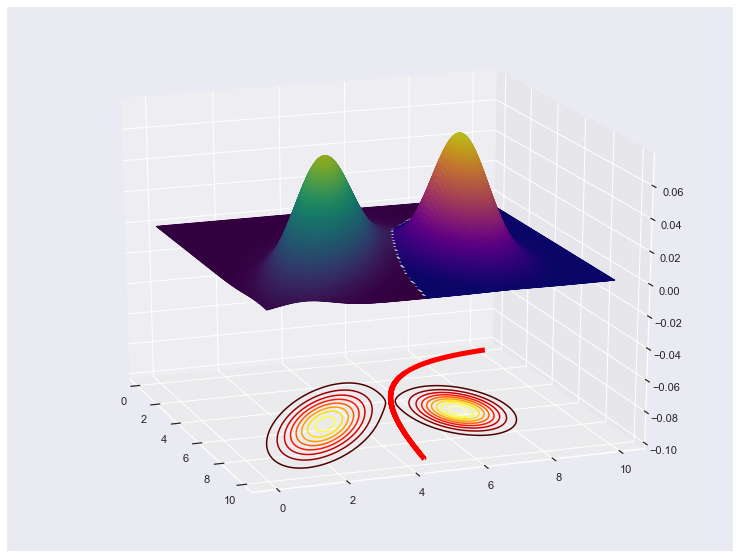

In [4]:
pdf.affiche_PDF_avec_contours(contours_remplis=False, affiche_labels=False, affiche_tickmarks=True)
# pdf.affiche_PDF_avec_contours(contours_remplis=False, affiche_labels=True, affiche_tickmarks=True)
